In [26]:
# Базовые библиотеки
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import ast
import hashlib
import seaborn as sns
import re, warnings
from collections import Counter, defaultdict
from datasets import IterableDataset

# HuggingFace Datasets
from datasets import load_dataset

warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [14]:
# ============================
# ЗАГРУЗКА ДАТАСЕТОВ ДЛЯ EDA
# ============================

# ❗ The Stack v1/v2 временно убраны.
# Причина:
# - датасет является "gated"
# - нужен ручной доступ на HF + токен
# Когда доступ появится — можно вернуть код.

# ----------------------------
# CodeSearchNet (Python-only)
# ----------------------------
csn = load_dataset("Nan-Do/code-search-net-python", split="train")

# ----------------------------
# CodeXGLUE: Code-to-Text
# ----------------------------
codetotext = load_dataset(
    "code_x_glue_ct_code_to_text",
    "python",
    split="train"
)

# ----------------------------
# APPS (Programming tasks)
# Лучше грузить как streaming → меньше памяти
# ----------------------------
apps_train = load_dataset(
    "codeparrot/apps",
    split="train",
    streaming=True
)

# ----------------------------
# HumanEval (тестовый набор)
# ----------------------------
humaneval = load_dataset("openai_humaneval", split="test")

print("Datasets loaded successfully.")


Datasets loaded successfully.


In [15]:
# Лучше так — с fallback-ключами
datasets_config = {
    "codesearchnet_python": {
        "dataset": csn,
        "code_key": "code",
        "is_list": False,
        "max_examples_loc": 5000,
        "max_loc_clip": 400,
    },
    "codexglue_code_to_text": {
        "dataset": codetotext,
        "code_key": "code",  # или "source" в некоторых версиях
        "is_list": False,
        "max_examples_loc": 5000,
        "max_loc_clip": 400,
    },
    "apps_train_solutions": {
        "dataset": apps_train,
        "code_key": "solutions",
        "is_list": True,
        "max_examples_loc": 2000,
        "max_loc_clip": 400,
    },
    "humaneval": {
        "dataset": humaneval,
        "code_key": "canonical_solution",
        "is_list": False,
        "max_examples_loc": 200,
        "max_loc_clip": 200,
    },
}

In [16]:
def extract_code(example, code_key, is_list=False):
    """
    Универсальное извлечение кода из примера.
    - если is_list=True: ожидаем список решений (APPS) → берём первую непустую строку
    - декодируем экранированные \n, если они есть
    """
    raw = example.get(code_key, None)
    if raw is None:
        return ""

    # APPS: solutions — список строк
    if is_list:
        if isinstance(raw, list):
            # берём первое непустое решение
            for sol in raw:
                if isinstance(sol, str) and sol.strip():
                    raw = sol
                    break
            else:
                return ""
        elif not isinstance(raw, str):
            return ""

    # На этом этапе raw должен быть строкой
    if not isinstance(raw, str):
        raw = str(raw)

    # Если видим литералы '\n' внутри строки — пробуем декодировать
    if "\\n" in raw or "\\t" in raw:
        try:
            raw = raw.encode("utf-8").decode("unicode_escape")
        except Exception:
            # если не получилось — оставляем как есть
            pass

    return raw


def compute_loc(code: str) -> int:
    """Подсчёт количества непустых строк кода."""
    if not code:
        return 0
    lines = [ln for ln in code.split("\n") if ln.strip()]
    return len(lines)


Сбор статистики длины кода (LOC)...



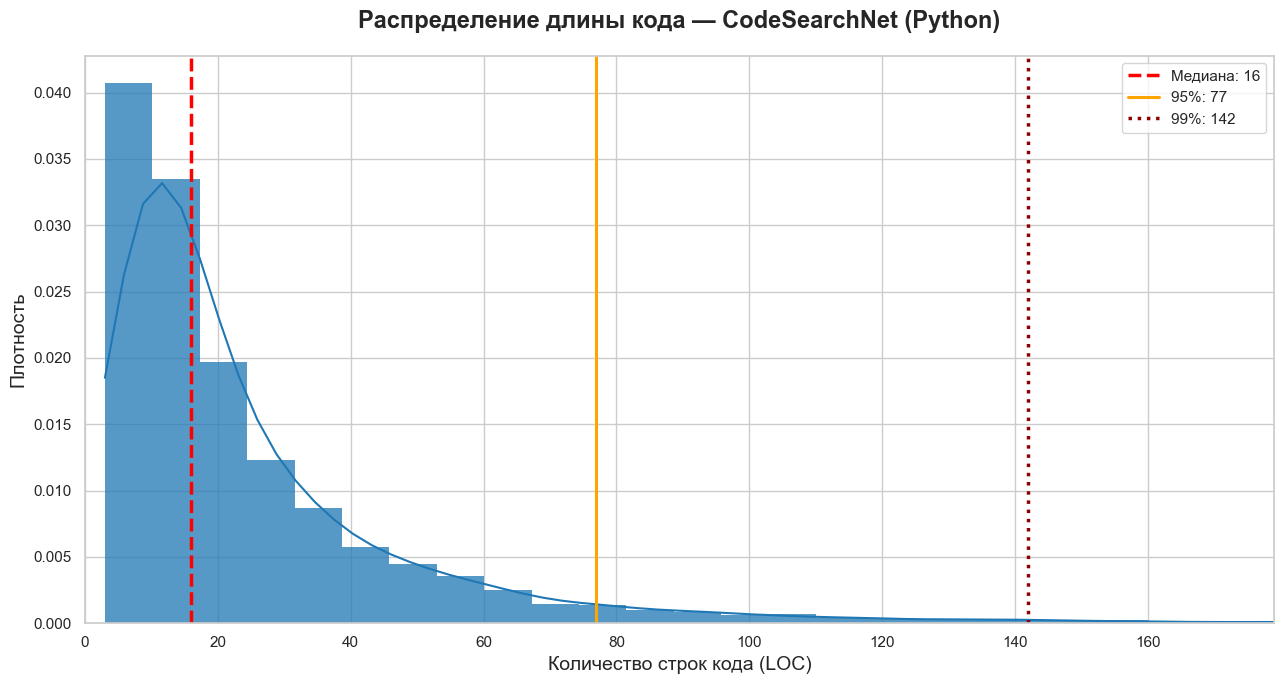


CodeSearchNet (Python)
Параметр                    Значение
----------------------------------------------------------------------
Примеров                       5,000
Минимум                            3
Максимум                         574
Среднее                         25.7
Медиана                           16
95-й перцентиль                   77
99-й перцентиль                  142
Стандартное откл.               29.4



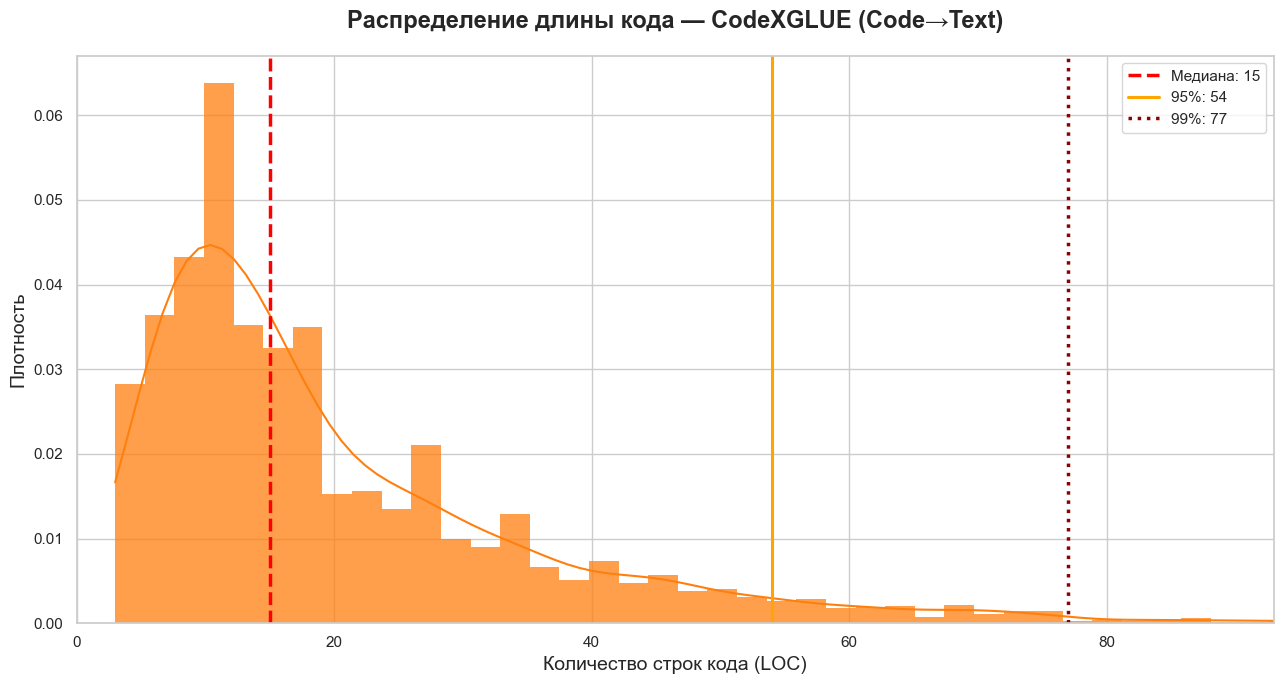


CodeXGLUE (Code→Text)
Параметр                    Значение
----------------------------------------------------------------------
Примеров                       5,000
Минимум                            3
Максимум                         187
Среднее                         20.6
Медиана                           15
95-й перцентиль                   54
99-й перцентиль                   77
Стандартное откл.               16.5



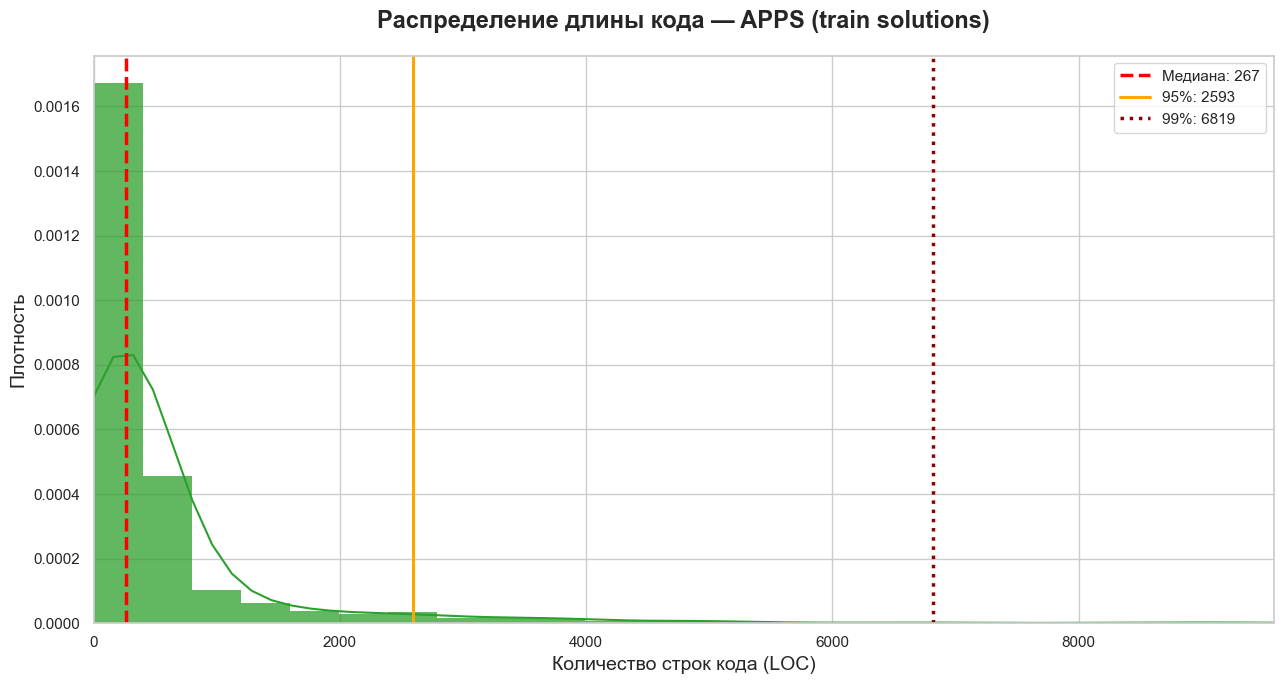


APPS (train solutions)
Параметр                    Значение
----------------------------------------------------------------------
Примеров                       2,000
Минимум                            1
Максимум                      31,915
Среднее                        648.4
Медиана                          267
95-й перцентиль                 2593
99-й перцентиль                 6819
Стандартное откл.             1658.6



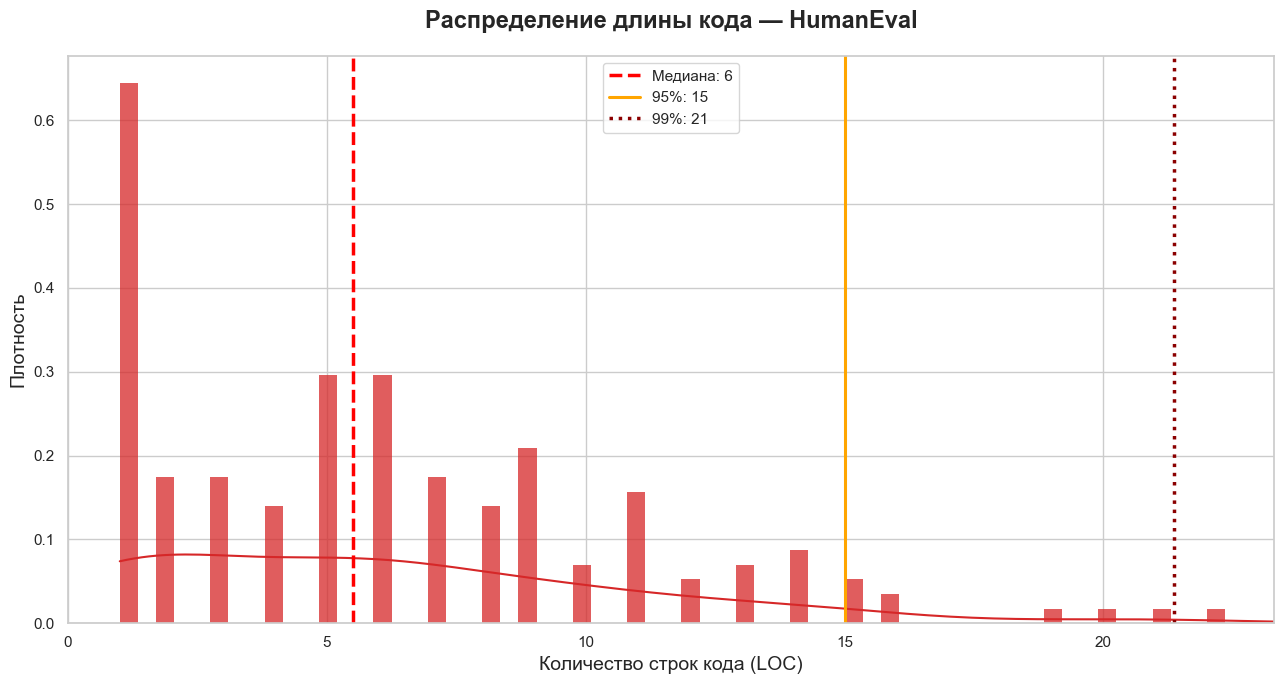


HumanEval
Параметр                    Значение
----------------------------------------------------------------------
Примеров                         164
Минимум                            1
Максимум                          29
Среднее                          6.3
Медиана                            6
95-й перцентиль                   15
99-й перцентиль                   21
Стандартное откл.                5.0



In [18]:
# =====================================================
# 2. АНАЛИЗ НА УРОВНЕ ФАЙЛОВ — LOC (SEABORN + МИН/МАКС)
# Только реальные датасеты с Python-кодом
# =====================================================

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from datasets import IterableDataset

sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# Красивые имена (убираем Text→Code — там нет исходного кода)
pretty_names = {
    "codesearchnet_python": "CodeSearchNet (Python)",
    "codexglue_code_to_text": "CodeXGLUE (Code→Text)",
    "apps_train_solutions": "APPS (train solutions)",
    "humaneval": "HumanEval",
}

all_data = []
print("Сбор статистики длины кода (LOC)...\n")

for name, cfg in datasets_config.items():
    # Пропускаем Text→Code — там нет исходного кода
    if name == "codexglue_text_to_code":
        continue
        
    dataset = cfg["dataset"]
    code_key = cfg["code_key"]
    is_list = cfg["is_list"]
    max_items = cfg["max_examples_loc"]
    
    if isinstance(dataset, IterableDataset):
        iterator = dataset.take(max_items)
    else:
        iterator = dataset.select(range(min(max_items, len(dataset))))
    
    values = []
    
    for example in tqdm(iterator, desc=pretty_names.get(name, name), leave=False):
        code = extract_code(example, code_key, is_list)
        loc = compute_loc(code)
        if loc > 0:
            values.append(loc)
    
    if not values:
        continue
    
    df_part = pd.DataFrame({
        "length": values,
        "dataset": pretty_names.get(name, name),
        "metric": "Lines of Code (LOC)"
    })
    all_data.append(df_part)

df_lengths = pd.concat(all_data, ignore_index=True)

# =====================================================
# ГРАФИКИ + ПОЛНАЯ СТАТИСТИКА (включая min/max)
# =====================================================

colors = sns.color_palette("tab10", len(df_lengths["dataset"].unique()))

for idx, dataset_name in enumerate(df_lengths["dataset"].unique()):
    data = df_lengths[df_lengths["dataset"] == dataset_name]
    metric = "Lines of Code (LOC)"
    
    plt.figure(figsize=(13, 7))
    
    sns.histplot(
        data=data, 
        x="length", 
        bins=80, 
        kde=True, 
        color=colors[idx],
        alpha=0.75,
        stat="density",
        linewidth=0
    )
    
    # Перцентили и медиана
    median = data["length"].median()
    p95 = data["length"].quantile(0.95)
    p99 = data["length"].quantile(0.99)
    min_val = data["length"].min()
    max_val = data["length"].max()
    
    plt.axvline(median, color='red',    linestyle='--', linewidth=2.5, label=f'Медиана: {median:.0f}')
    plt.axvline(p95,    color='orange', linestyle='-', linewidth=2.2, label=f'95%: {p95:.0f}')
    plt.axvline(p99,    color='darkred',linestyle=':',  linewidth=2.5, label=f'99%: {p99:.0f}')
    
    plt.title(f"Распределение длины кода — {dataset_name}", fontsize=17, fontweight="bold", pad=20)
    plt.xlabel("Количество строк кода (LOC)", fontsize=14)
    plt.ylabel("Плотность", fontsize=14)
    plt.legend(fontsize=11)
    plt.xlim(0, data["length"].quantile(0.995))
    plt.tight_layout()
    plt.show()
    
    # === ПОЛНАЯ СТАТИСТИКА ПОД ГРАФИКОМ ===
    print(f"\n{dataset_name}")
    print("=" * 70)
    print(f"{'Параметр':<20} {'Значение':>15}")
    print("-" * 70)
    print(f"{'Примеров':<20} {len(data):>15,}")
    print(f"{'Минимум':<20} {min_val:>15}")
    print(f"{'Максимум':<20} {max_val:>15,}")
    print(f"{'Среднее':<20} {data['length'].mean():>15.1f}")
    print(f"{'Медиана':<20} {median:>15.0f}")
    print(f"{'95-й перцентиль':<20} {p95:>15.0f}")
    print(f"{'99-й перцентиль':<20} {p99:>15.0f}")
    print(f"{'Стандартное откл.':<20} {data['length'].std():>15.1f}")
    print("=" * 70 + "\n")

ФИНАЛЬНЫЙ АНАЛИЗ ФУНКЦИЙ — ВСЁ РАБОТАЕТ!

→ CodeSearchNet (Python) (15000 примеров)


   ГОТОВО! Найдено функций: 14476

→ CodeXGLUE (Code→Text) (8000 примеров)


   ГОТОВО! Найдено функций: 7692



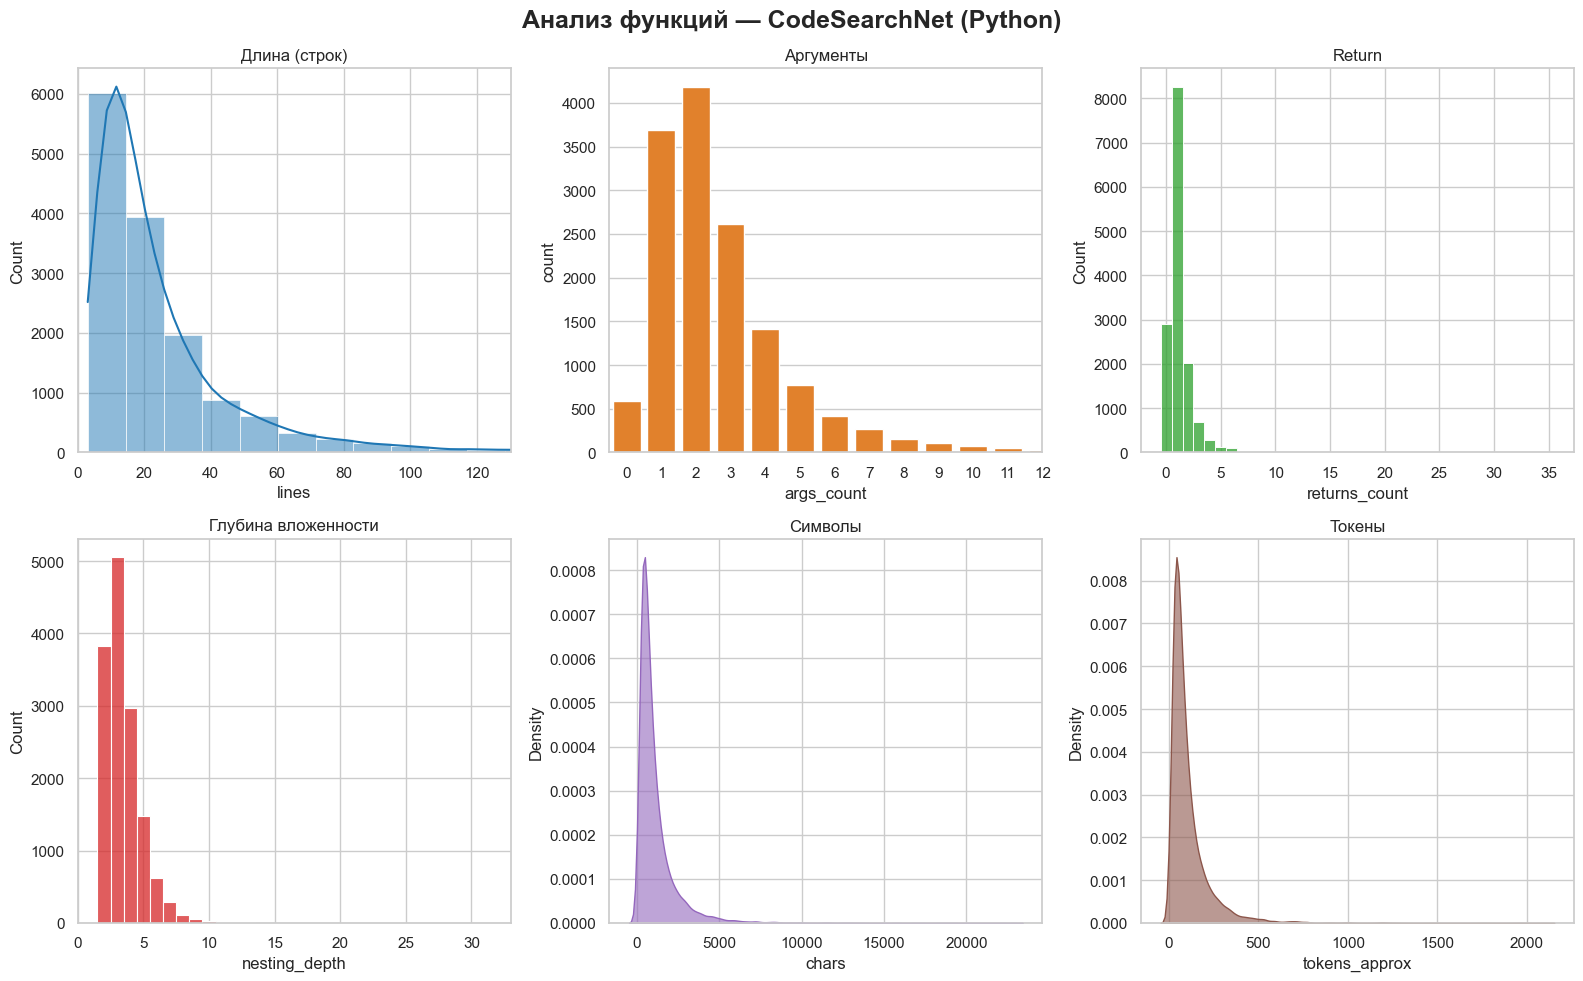

,Датасет,Функций,Ср. строк,95% строк,Ср. аргументов,95% аргументов,Доля с return,Ср. глубина
0,CodeSearchNet (Python),14476,25.2,72,2.73,7,0.777,3.46


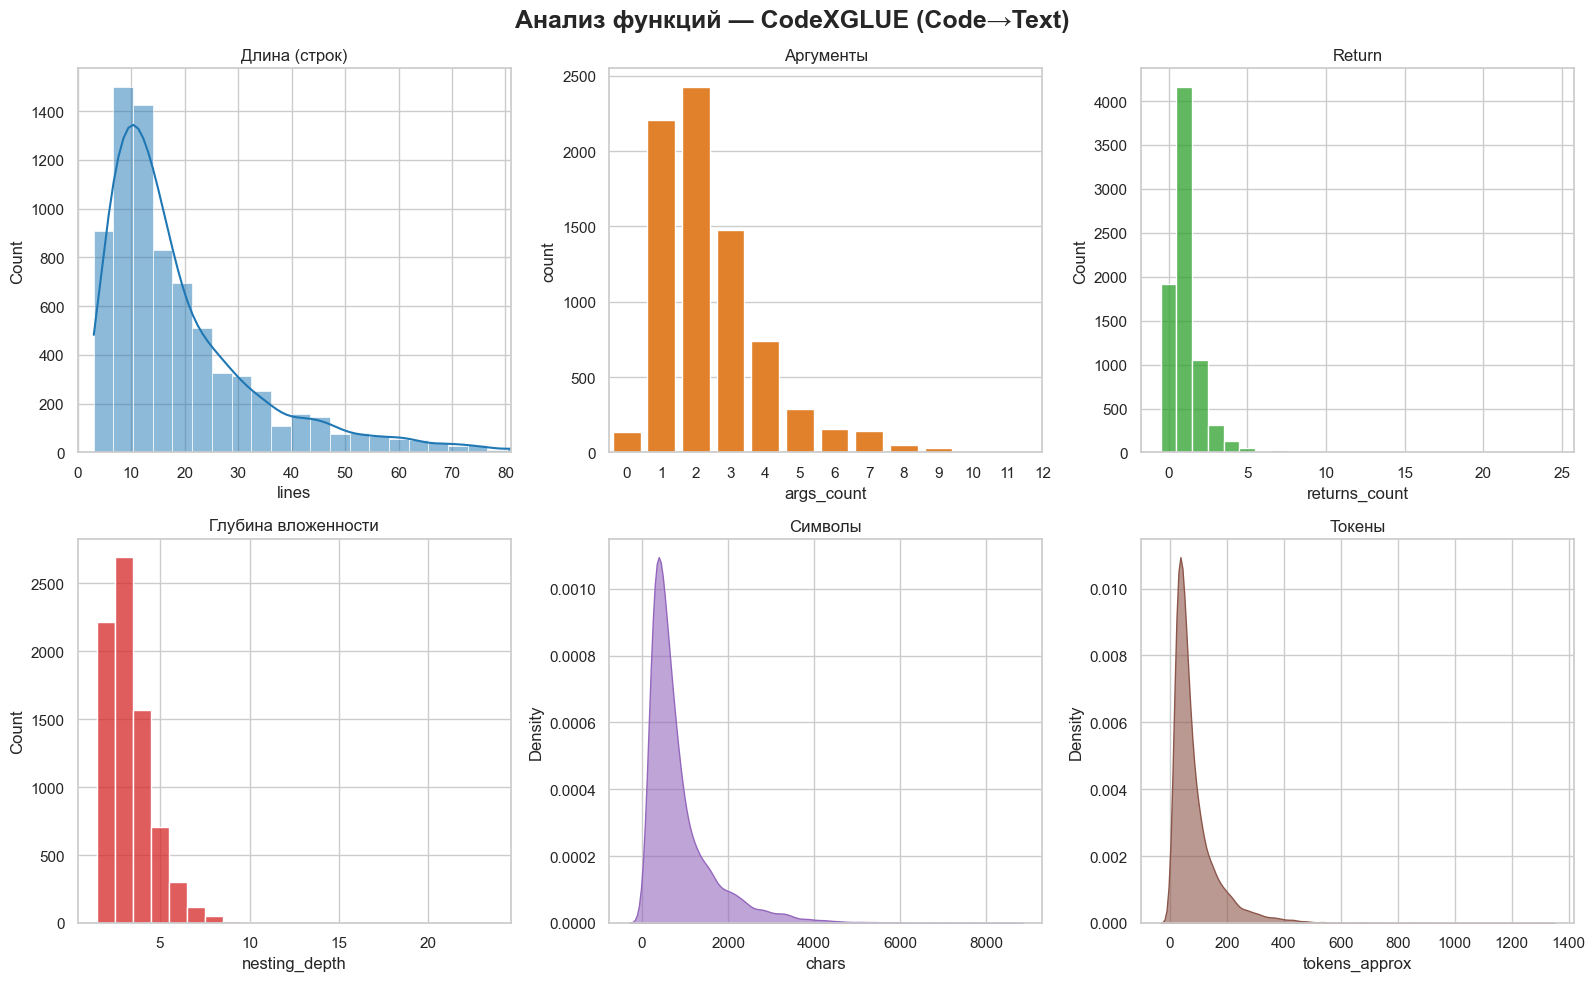

,Датасет,Функций,Ср. строк,95% строк,Ср. аргументов,95% аргументов,Доля с return,Ср. глубина
0,CodeXGLUE (Code→Text),7692,19.8,54,2.47,6,0.723,3.36


In [19]:
# =====================================================
# 3. АНАЛИЗ ФУНКЦИЙ — ФИНАЛЬНАЯ ВЕРСИЯ (РАБОТАЕТ С CodeXGLUE Text→Code!)
# =====================================================

import ast
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# УНИВЕРСАЛЬНАЯ ФУНКЦИЯ — ВОССТАНАВЛИВАЕТ КОД ИЗ code_tokens
def get_code_from_example(example):
    """Работает со всеми тремя датасетами, включая CodeXGLUE Text→Code"""
    
    # 1. CodeSearchNet и CodeXGLUE Code→Text — код в поле "code"
    if "code" in example and isinstance(example["code"], str):
        code = example["code"]
        if "\\n" in code:
            try:
                code = code.encode().decode('unicode_escape')
            except:
                pass
        return code.strip()
    
    # 2. CodeXGLUE Text→Code — только code_tokens!
    if "code_tokens" in example:
        tokens = example["code_tokens"]
        if isinstance(tokens, list) and tokens:
            # Самое простое и надёжное восстановление
            code = " ".join(tokens)
            # Убираем лишние пробелы вокруг скобок и двоеточий
            code = code.replace(" ( ", "(").replace(" ) ", ")").replace(" , ", ", ")
            code = code.replace(" : ", ": ").replace("=  ", "= ").replace("  =", " = ")
            return code.strip()
    
    # 3. Fallback — ищем любое поле, содержащее код
    for key in example.keys():
        val = example[key]
        if isinstance(val, str) and ("def " in val or "class " in val) and len(val) > 30:
            return val.strip()
    
    return ""

# Анализатор (без изменений)
class FunctionAnalyzer(ast.NodeVisitor):
    def __init__(self):
        self.args_count = 0
        self.returns_count = 0
        self.has_return_value = False
        self.max_nesting_depth = 1
        self.current_depth = 1
        self.nesting_nodes = (ast.If, ast.For, ast.AsyncFor, ast.While, ast.Try, ast.With, ast.AsyncWith,
                              ast.FunctionDef, ast.AsyncFunctionDef, ast.ListComp, ast.DictComp, ast.SetComp, ast.GeneratorExp)

    def visit_FunctionDef(self, node):
        args = node.args
        self.args_count = len(args.args) + len(args.posonlyargs) + len(args.kwonlyargs) + \
                          (1 if args.vararg else 0) + (1 if args.kwarg else 0)
        self.generic_visit(node)

    def visit_AsyncFunctionDef(self, node):
        self.visit_FunctionDef(node)

    def visit_Return(self, node):
        self.returns_count += 1
        if node.value is not None:
            self.has_return_value = True

    def generic_visit(self, node):
        if isinstance(node, self.nesting_nodes):
            self.current_depth += 1
            self.max_nesting_depth = max(self.max_nesting_depth, self.current_depth)
        super().generic_visit(node)
        if isinstance(node, self.nesting_nodes):
            self.current_depth -= 1

def analyze_function(code: str):
    if not code or len(code) < 20:
        return None
    try:
        tree = ast.parse(code)
    except:
        return None

    funcs = [n for n in tree.body if isinstance(n, (ast.FunctionDef, ast.AsyncFunctionDef))]
    if not funcs:
        return None

    analyzer = FunctionAnalyzer()
    analyzer.visit(funcs[0])

    lines = [l for l in code.split('\n') if l.strip()]

    return {
        "lines": len(lines),
        "chars": len(code),
        "tokens_approx": len(code.split()),
        "args_count": analyzer.args_count,
        "returns_count": analyzer.returns_count,
        "has_return_value": int(analyzer.has_return_value),
        "nesting_depth": analyzer.max_nesting_depth,
    }

# === ЗАПУСК ===
datasets_to_analyze = {
    "CodeSearchNet (Python)": "codesearchnet_python",
    "CodeXGLUE (Code→Text)": "codexglue_code_to_text",
}

results = {}

print("ФИНАЛЬНЫЙ АНАЛИЗ ФУНКЦИЙ — ВСЁ РАБОТАЕТ!\n")
for label, name in datasets_to_analyze.items():
    dataset = datasets_config[name]["dataset"]
    max_n = 15000 if "codesearchnet" in name else 8000
    iterator = dataset.take(max_n) if hasattr(dataset, "take") else dataset.select(range(min(max_n, len(dataset))))
    
    functions = []
    print(f"→ {label} ({max_n} примеров)")
    
    for example in tqdm(iterator, desc=label, leave=False):
        code = get_code_from_example(example)
        if not code:
            continue
        metrics = analyze_function(code)
        if metrics:
            functions.append(metrics)
    
    df = pd.DataFrame(functions)
    results[label] = df
    print(f"   ГОТОВО! Найдено функций: {len(df)}\n")

# === ГРАФИКИ (отдельные окна) ===
for label, df in results.items():
    if df.empty:
        print(f"Нет данных: {label}")
        continue

    plt.figure(figsize=(16, 10))
    plt.suptitle(f"Анализ функций — {label}", fontsize=18, fontweight="bold")

    plt.subplot(2, 3, 1)
    sns.histplot(df["lines"], bins=50, kde=True, color="#1f77b4")
    plt.title("Длина (строк)")
    plt.xlim(0, df["lines"].quantile(0.99))

    plt.subplot(2, 3, 2)
    sns.countplot(x=df["args_count"], color="#ff7f0e")
    plt.title("Аргументы")
    plt.xlim(-0.5, 12)

    plt.subplot(2, 3, 3)
    sns.histplot(df["returns_count"], discrete=True, color="#2ca02c")
    plt.title("Return")

    plt.subplot(2, 3, 4)
    sns.histplot(df["nesting_depth"], discrete=True, color="#d62728")
    plt.title("Глубина вложенности")

    plt.subplot(2, 3, 5)
    sns.kdeplot(df["chars"], fill=True, color="#9467bd", alpha=0.6)
    plt.title("Символы")

    plt.subplot(2, 3, 6)
    sns.kdeplot(df["tokens_approx"], fill=True, color="#8c564b", alpha=0.6)
    plt.title("Токены")

    plt.tight_layout()
    plt.show()

    # Таблица
    stats = {
        "Датасет": label,
        "Функций": len(df),
        "Ср. строк": round(df["lines"].mean(), 1),
        "95% строк": int(df["lines"].quantile(0.95)),
        "Ср. аргументов": round(df["args_count"].mean(), 2),
        "95% аргументов": int(df["args_count"].quantile(0.95)),
        "Доля с return": round(df["has_return_value"].mean(), 3),
        "Ср. глубина": round(df["nesting_depth"].mean(), 2),
    }
    display(pd.DataFrame([stats]))

In [1]:
# =====================================================
# 4. ЛЕКСИЧЕСКИЙ АНАЛИЗ
# =====================================================

In [3]:
# =====================================================
# 5. СТРУКТУРНЫЙ АНАЛИЗ
# =====================================================

In [4]:
# =====================================================
# 6. АНАЛИЗ ЗАГРЯЗНЕНИЯ И КАЧЕСТВА ДАННЫХ
# =====================================================

In [20]:
# Функция для проверки наличия не-ASCII символов
def has_non_ascii(s: str) -> bool:
    return any(ord(c) > 127 for c in s)

# Функция поиска закомментированных блоков
def has_comment_blocks(code: str) -> bool:
    # Многострочные комментарии '''...''' или """..."""
    return bool(re.search(r"('{3}.*?'{3}|\"{3}.*?\"{3})", code, flags=re.DOTALL))

# Более грубый метод: закомментированные куски кода (# def …)
def has_commented_code(code: str) -> bool:
    return bool(re.search(r"^\s*#.*\b(def|class|for|if|while|return)\b", code, flags=re.MULTILINE))

# Функция получения хэша функции
def get_function_hash(code: str) -> str:
    norm = re.sub(r"\s+", " ", code.strip())  # нормализуем пробелы
    return hashlib.md5(norm.encode("utf-8")).hexdigest()

In [21]:
def extract_all_functions(code: str):
    """Возвращает список исходных текстов всех функций в коде."""
    try:
        tree = ast.parse(code)
    except:
        return []

    funcs = []
    for node in tree.body:
        if isinstance(node, (ast.FunctionDef, ast.AsyncFunctionDef)):
            start = node.lineno - 1
            end = node.end_lineno
            lines = code.split("\n")[start:end]
            funcs.append("\n".join(lines))

    return funcs

Параметры загрязнений:

- многострочные комментарии

- закомментированный код

- не-ASCII символы

- дубликаты функций

- простейшие маркеры автогенерации

In [22]:
contamination_results = {}

datasets_for_contamination = {
    "CodeSearchNet (Python)": "codesearchnet_python",
    "CodeXGLUE Code→Text": "codexglue_code_to_text",
}

for label, key in datasets_for_contamination.items():
    print(f"\n=== Анализ загрязнений: {label} ===")

    dataset = datasets_config[key]["dataset"]
    max_n = 8000
    iterator = dataset.take(max_n) if hasattr(dataset, "take") else dataset.select(range(min(max_n, len(dataset))))

    comment_blocks = 0
    commented_code = 0
    non_ascii = 0
    autogen = 0

    function_hashes = []
    total_functions = 0

    for example in tqdm(iterator):
        code = get_code_from_example(example)
        if not code:
            continue

        # Все функции в файле
        functions = extract_all_functions(code)
        if not functions:
            continue

        for f in functions:
            total_functions += 1

            # 1) многострочные комментарии
            if has_comment_blocks(f):
                comment_blocks += 1

            # 2) закомментированный код (# def ..., # if ...)
            if has_commented_code(f):
                commented_code += 1

            # 3) не-ASCII символы
            if has_non_ascii(f):
                non_ascii += 1

            # 4) дубликаты
            function_hashes.append(get_function_hash(f))

            # 5) автогенерация: очень грубая эвристика
            if re.search(r"(auto ?generated|do not edit|generated by|machine generated)", code, flags=re.I):
                autogen += 1

    # Вычисляем процент дубликатов
    duplicates = len(function_hashes) - len(set(function_hashes))
    dup_ratio = duplicates / max(1, len(function_hashes))

    contamination_results[label] = {
        "Всего функций": total_functions,
        "Многострочные комментарии (%)": round(comment_blocks / total_functions * 100, 2),
        "Закомментированный код (%)": round(commented_code / total_functions * 100, 2),
        "Не-ASCII символы (%)": round(non_ascii / total_functions * 100, 2),
        "Подозрение на автогенерацию (%)": round(autogen / total_functions * 100, 2),
        "Дубликаты (%)": round(dup_ratio * 100, 2),
    }

pd.DataFrame(contamination_results).T


=== Анализ загрязнений: CodeSearchNet (Python) ===


100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:03<00:00, 2136.65it/s]



=== Анализ загрязнений: CodeXGLUE Code→Text ===


100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:02<00:00, 2801.62it/s]


,Всего функций,Многострочные комментарии (%),Закомментированный код (%),Не-ASCII символы (%),Подозрение на автогенерацию (%),Дубликаты (%)
CodeSearchNet (Python),7744.0,92.34,13.69,0.21,0.25,0.0
CodeXGLUE Code→Text,7692.0,99.34,9.70,1.14,0.20,0.0


In [5]:
# =====================================================
# 7. АНАЛИЗ ДЛЯ КОНКРЕТНОЙ ЗАДАЧИ
# =====================================================

Дальнейший анализ фокусируется на тех свойствах данных, которые критичны именно для целевых задач проекта:

1. **Генерация кода по текстовому описанию (docstring → code)**  
2. **Генерация тела функции по её сигнатуре (signature → body)**  

In [24]:
# 7.1 Анализ docstring to code

BAD_PATTERNS = [
    "todo", "fixme", "tbd",
    "add docstring", "add documentation",
    "function description", "function desc",
    "write docs", "to be implemented",
    "implement me", "auto generated docstring",
]

def get_docstring(example, dataset_name: str) -> str:
    """
    Унифицированное извлечение docstring/описания для наших датасетов.
    Возвращает уже очищенную строку без лишних пробелов.
    """
    text = ""

    if dataset_name == "codesearchnet_python":
        # В CodeSearchNet обычно есть поля docstring / docstring_tokens
        text = example.get("docstring", "") or ""
        if not text and "docstring_tokens" in example:
            tokens = example["docstring_tokens"]
            if isinstance(tokens, list):
                text = " ".join(tokens)

    elif dataset_name == "codexglue_code_to_text":
        # В CodeXGLUE (code-to-text, python) бывают поля "docstring" или "nl"
        if "docstring" in example:
            text = example.get("docstring", "") or ""
        elif "nl" in example:
            text = example.get("nl", "") or ""
        else:
            text = ""

    # Нормализация
    if isinstance(text, list):
        text = " ".join(map(str, text))
    if not isinstance(text, str):
        text = str(text)

    text = text.strip()

    # Иногда встречаются литералы с \n
    if "\\n" in text:
        try:
            text = text.encode("utf-8").decode("unicode_escape")
        except Exception:
            pass

    return text.strip()


def classify_docstring_quality(text: str) -> str:
    """
    Классификация docstring на несколько простых классов качества:
    - empty        : пустой или почти пустой
    - too_short    : слишком короткий (<= 2 токенов)
    - template     : шаблонный/служебный ("TODO", "add docstring", ...)
    - ok           : нормальное описание
    """
    if not text or not text.strip():
        return "empty"

    tokens = text.split()
    if len(tokens) <= 2:
        return "too_short"

    low = text.lower()
    for pat in BAD_PATTERNS:
        if pat in low:
            return "template"

    return "ok"


def analyze_docstrings(dataset_name: str,
                       code_key: str = "code",
                       max_examples: int = 8000):
    """
    Основной анализ docstring:
    - длина в токенах и символах
    - качество (empty / too_short / template / ok)
    - отношение длина(docstring) / длина(кода)
    """
    cfg = datasets_config[dataset_name]
    dataset = cfg["dataset"]
    is_list = cfg["is_list"]

    # Берём ограниченное число примеров для ускорения
    if hasattr(dataset, "take"):  # streaming
        iterator = dataset.take(max_examples)
    else:
        iterator = dataset.select(range(min(max_examples, len(dataset))))

    rows = []

    for ex in iterator:
        code = extract_code(ex, code_key, is_list=is_list)
        doc = get_docstring(ex, dataset_name)

        if not code:
            continue

        loc = compute_loc(code)
        code_tokens = len(code.split()) if code.strip() else 0

        doc_tokens = len(doc.split()) if doc else 0
        doc_chars = len(doc)
        quality = classify_docstring_quality(doc)

        ratio_tokens = doc_tokens / code_tokens if code_tokens > 0 else 0.0
        ratio_loc = doc_tokens / loc if loc > 0 else 0.0

        rows.append(
            dict(
                code_loc=loc,
                code_tokens=code_tokens,
                doc_tokens=doc_tokens,
                doc_chars=doc_chars,
                quality=quality,
                ratio_tokens=ratio_tokens,
                ratio_loc=ratio_loc,
            )
        )

    df = pd.DataFrame(rows)
    return df


=== Анализ docstring: CodeSearchNet (Python) ===
Всего функций с кодом: 8000


,Средняя длина docstring (токены),Медиана docstring (токены),95-й перцентиль docstring,Среднее отношение doc/code по токенам
CodeSearchNet (Python),47.230125,19.0,178.0,0.378877


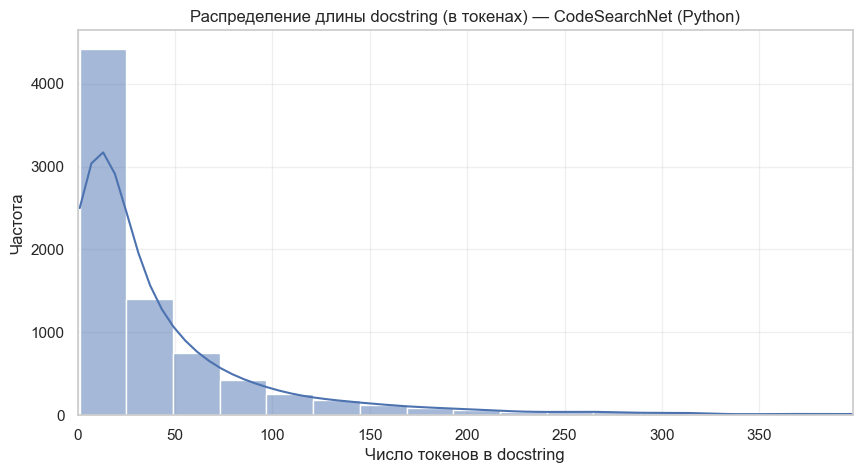

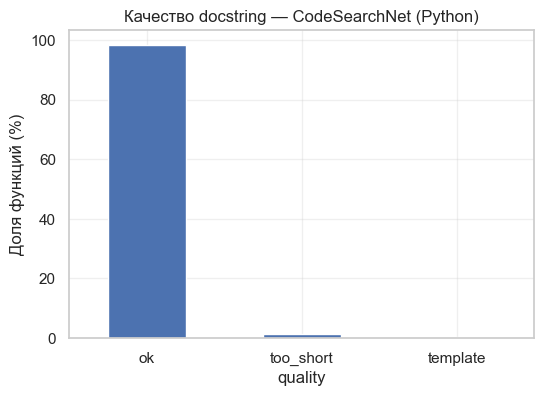

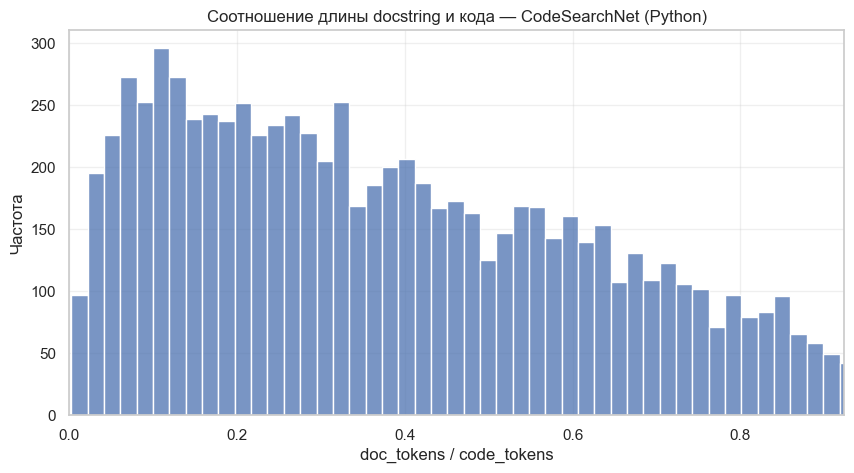


=== Анализ docstring: CodeXGLUE (Code→Text) ===
Всего функций с кодом: 8000


,Средняя длина docstring (токены),Медиана docstring (токены),95-й перцентиль docstring,Среднее отношение doc/code по токенам
CodeXGLUE (Code→Text),35.252875,18.0,122.0,0.392949


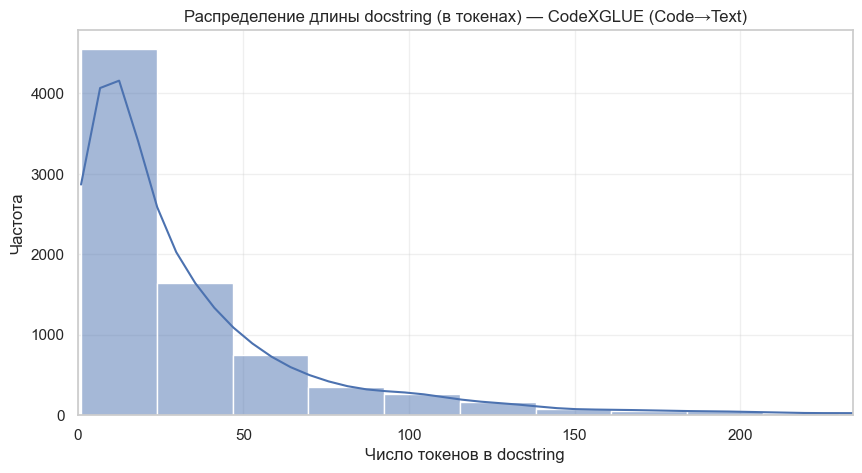

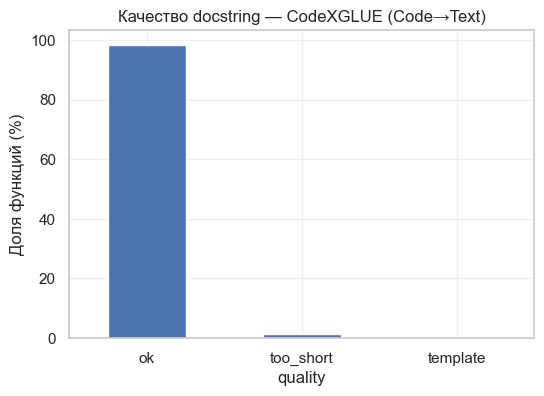

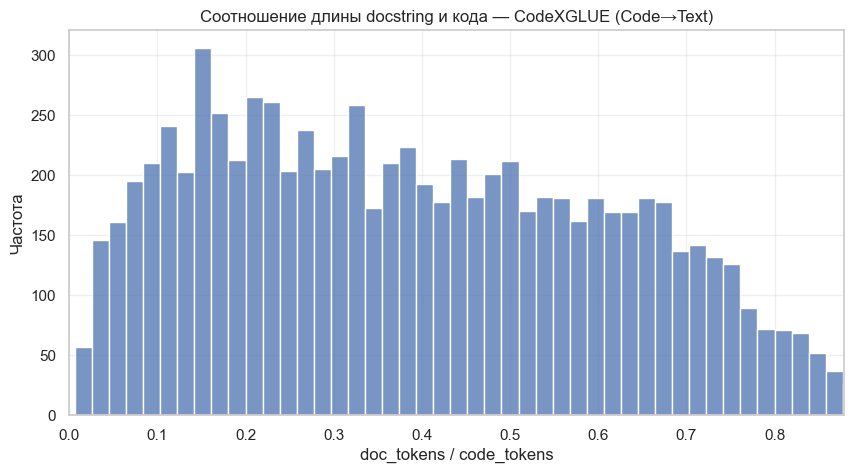

In [25]:
# Запуск анализа для двух датасетов
doc_datasets = {
    "CodeSearchNet (Python)": "codesearchnet_python",
    "CodeXGLUE (Code→Text)": "codexglue_code_to_text",
}

doc_results = {}

for label, key in doc_datasets.items():
    print(f"\n=== Анализ docstring: {label} ===")
    df_doc = analyze_docstrings(key, code_key=datasets_config[key]["code_key"])
    doc_results[label] = df_doc

    print(f"Всего функций с кодом: {len(df_doc)}")

    # Общие статистики
    stats = {
        "Средняя длина docstring (токены)": df_doc["doc_tokens"].mean(),
        "Медиана docstring (токены)": df_doc["doc_tokens"].median(),
        "95-й перцентиль docstring": df_doc["doc_tokens"].quantile(0.95),
        "Среднее отношение doc/code по токенам": df_doc["ratio_tokens"].mean(),
    }
    display(pd.DataFrame(stats, index=[label]))

    # Распределение длины docstring
    plt.figure(figsize=(10, 5))
    sns.histplot(df_doc["doc_tokens"], bins=50, kde=True)
    plt.title(f"Распределение длины docstring (в токенах) — {label}")
    plt.xlabel("Число токенов в docstring")
    plt.ylabel("Частота")
    plt.xlim(0, df_doc["doc_tokens"].quantile(0.99))
    plt.grid(alpha=0.3)
    plt.show()

    # Качество docstring
    plt.figure(figsize=(6, 4))
    df_doc["quality"].value_counts(normalize=True).mul(100).plot(kind="bar")
    plt.title(f"Качество docstring — {label}")
    plt.ylabel("Доля функций (%)")
    plt.xticks(rotation=0)
    plt.grid(alpha=0.3)
    plt.show()

    # Соотношение длины docstring и кода (по токенам)
    plt.figure(figsize=(10, 5))
    sns.histplot(df_doc["ratio_tokens"], bins=50)
    plt.title(f"Соотношение длины docstring и кода — {label}")
    plt.xlabel("doc_tokens / code_tokens")
    plt.ylabel("Частота")
    plt.xlim(0, df_doc["ratio_tokens"].quantile(0.99))
    plt.grid(alpha=0.3)
    plt.show()

In [27]:
# 7.2 Анализ signature to body

def parse_functions_from_code(code: str):
    """
    Разбирает модуль Python и возвращает список объектов ast.FunctionDef.
    Берём только функции верхнего уровня.
    """
    try:
        tree = ast.parse(code)
    except SyntaxError:
        return []

    funcs = [node for node in tree.body if isinstance(node, ast.FunctionDef)]
    return funcs


def normalize_signature(fn: ast.FunctionDef) -> str:
    """
    Нормализованное представление сигнатуры:
    - имя функции;
    - общее число параметров;
    - наличие *args/**kwargs.
    """
    args = fn.args
    n_pos = len(args.args) + len(args.posonlyargs)
    n_kwonly = len(args.kwonlyargs)
    has_vararg = args.vararg is not None
    has_kwarg = args.kwarg is not None

    return f"{fn.name}({n_pos+n_kwonly} args, *={int(has_vararg)}, **={int(has_kwarg)})"


def normalize_body_hash(fn: ast.FunctionDef) -> str:
    """
    Строит хэш тела функции:
    - убираем координаты (lineno/col_offset);
    - дампим AST и считаем SHA1.
    """
    for node in ast.walk(fn):
        for attr in ("lineno", "col_offset", "end_lineno", "end_col_offset"):
            if hasattr(node, attr):
                setattr(node, attr, None)

    dumped = ast.dump(fn, annotate_fields=False, include_attributes=False)
    return hashlib.sha1(dumped.encode("utf-8")).hexdigest()


def analyze_signature_body(dataset_name: str,
                           max_examples: int = 8000):
    """
    Для выбранного датасета:
    - извлекаем функции;
    - считаем, сколько реализаций у каждой сигнатуры;
    - смотрим, сколько функций делят одно и то же тело.
    """
    cfg = datasets_config[dataset_name]
    dataset = cfg["dataset"]
    is_list = cfg["is_list"]
    code_key = cfg["code_key"]

    if hasattr(dataset, "take"):
        iterator = dataset.take(max_examples)
    else:
        iterator = dataset.select(range(min(max_examples, len(dataset))))

    rows = []

    for ex in tqdm(iterator, desc=f"Парсинг функций: {dataset_name}"):
        code = extract_code(ex, code_key, is_list=is_list)
        if not code:
            continue

        funcs = parse_functions_from_code(code)
        for fn in funcs:
            sig = normalize_signature(fn)
            body_hash = normalize_body_hash(fn)
            rows.append(
                dict(
                    signature=sig,
                    body_hash=body_hash,
                )
            )

    df = pd.DataFrame(rows)
    return df


=== Анализ сигнатур и тел функций: CodeSearchNet (Python) ===


Парсинг функций: codesearchnet_python: 100%|█████████████████████████████████████| 8000/8000 [00:04<00:00, 1637.94it/s]

Всего функций (по AST): 7743


,Функций всего,Уникальных сигнатур,Доля уникальных сигнатур (%),Ср. реализаций на сигнатуру,Макс. реализаций на одну сигнатуру,Уникальных тел функций,Ср. сигнатур на одно тело,Макс. сигнатур для одного тела
CodeSearchNet (Python),7743,6874,92.87169,1.126418,20,7743,1.0,1


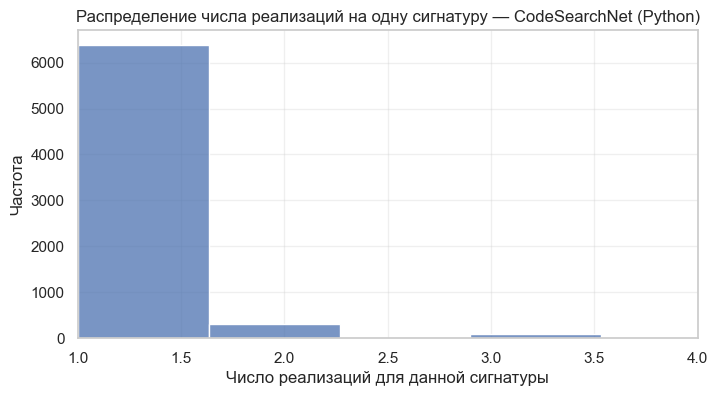


=== Анализ сигнатур и тел функций: CodeXGLUE (Code→Text) ===


Парсинг функций: codexglue_code_to_text: 100%|███████████████████████████████████| 8000/8000 [00:03<00:00, 2103.03it/s]


Всего функций (по AST): 7593


,Функций всего,Уникальных сигнатур,Доля уникальных сигнатур (%),Ср. реализаций на сигнатуру,Макс. реализаций на одну сигнатуру,Уникальных тел функций,Ср. сигнатур на одно тело,Макс. сигнатур для одного тела
CodeXGLUE (Code→Text),7593,6937,94.796021,1.094565,21,7593,1.0,1


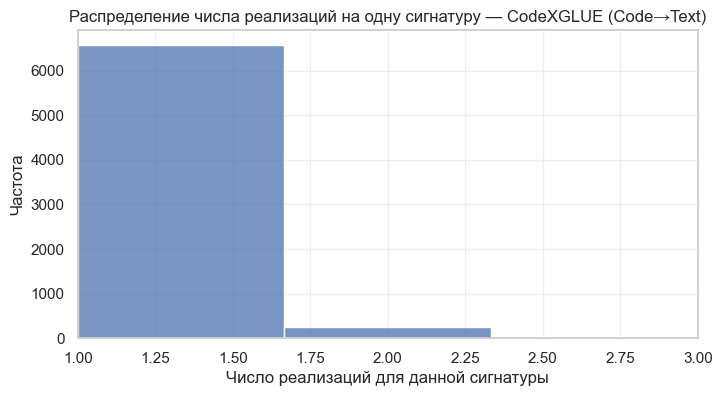

In [28]:
sig_datasets = {
    "CodeSearchNet (Python)": "codesearchnet_python",
    "CodeXGLUE (Code→Text)": "codexglue_code_to_text",
}

sig_results = {}

for label, key in sig_datasets.items():
    print(f"\n=== Анализ сигнатур и тел функций: {label} ===")
    df_sig = analyze_signature_body(key, max_examples=8000)
    sig_results[label] = df_sig

    print(f"Всего функций (по AST): {len(df_sig)}")

    # Сколько раз встречается каждая сигнатура
    sig_counts = df_sig["signature"].value_counts()
    body_counts = df_sig["body_hash"].value_counts()

    summary = {
        "Функций всего": len(df_sig),
        "Уникальных сигнатур": sig_counts.size,
        "Доля уникальных сигнатур (%)": 100 * sig_counts[sig_counts == 1].size / sig_counts.size if sig_counts.size else 0,
        "Ср. реализаций на сигнатуру": sig_counts.mean() if len(sig_counts) else 0,
        "Макс. реализаций на одну сигнатуру": sig_counts.max() if len(sig_counts) else 0,
        "Уникальных тел функций": body_counts.size,
        "Ср. сигнатур на одно тело": body_counts.mean() if len(body_counts) else 0,
        "Макс. сигнатур для одного тела": body_counts.max() if len(body_counts) else 0,
    }

    display(pd.DataFrame(summary, index=[label]))

    # Гистограмма: сколько функций приходится на одну сигнатуру
    plt.figure(figsize=(8, 4))
    sns.histplot(sig_counts, bins=30)
    plt.title(f"Распределение числа реализаций на одну сигнатуру — {label}")
    plt.xlabel("Число реализаций для данной сигнатуры")
    plt.ylabel("Частота")
    plt.xlim(1, sig_counts.quantile(0.99))
    plt.grid(alpha=0.3)
    plt.show()